In [1]:
import sys
import os
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegFileWriter
import pandas as pd
sys.path.insert(0, './magcolloids')

import magcolloids as mgc
#pint parameter
ureg = mgc.ureg

Function for the field re-definition in LAMMPS (Inclination)

In [2]:
def redefine_field(field,tilt_angle):
    field.fieldx = 'v_Bmag*(sin(v_freq*time*2*PI)*sin(v_theta)+cos(v_theta)*%s)'%np.sin(tilt_angle).magnitude
    field.fieldy = 'v_Bmag*(cos(v_freq*time*2*PI)*sin(v_theta))'%np.sin(tilt_angle).magnitude
    field.fieldz = 'v_Bmag*(cos(v_theta)*%s)'%np.cos(tilt_angle).magnitude
    return field

In [3]:
n_sqrd = 5
num_of_particles = n_sqrd**2
tilted_field = True
region, initial_conditions = mgc.initial_setup(num_of_particles, packing = 0.3, height = 4, radius = 1.4)

### Definition of the System's Parameters
We are trying to generate a system in which we see the ceilidh-like pattern, and in which there's a trapped particle that allows us to track the MBR (Stationary system is needed to analyze this), while this pattern is still present. For this, the following characteristics are considered:
 - Theres one trapped particle, creating a bidisperse trap with distance 0 (an harmonic trap), and an stiffness adequate.
 - The normal parameters established in (10.1103/PhysRevResearch.2.012025), in order to generate the ceilidh-like movement. This include not only the field but the packing and the characteristics of the particles.

We should try to look for the right amount of: particles and stiffness, in order to have a reliable measurements of the system. In specific, we should try to work out the difference between a system 10^2 and 5^2.

We should work both with a system with a titled magnetic field, but also with a normal magnetic field, as when we have the tilt that those the ceilidh-like pattern, we can clearly see that it generates a current with the particle movement.

In [4]:
particle_radius = 1.4

particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = particle_radius*ureg.um,
    susceptibility = 0.4,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 1e3*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

# Trap of Track Particle
stiffness_track = 15e-4
track_particle = 10

trap_track = mgc.bistable_trap(
                initial_conditions[track_particle:track_particle+1,:]*ureg.um,
                np.array([[1,0,0]]),
                particles, subsets = [track_particle],
                distance = 0*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = stiffness_track*ureg.pN/ureg.nm)

field = mgc.field(magnitude = 7.2*ureg.mT, frequency = 3*ureg.Hz, angle = 26.9*ureg.degrees)

if tilted_field:
    field = redefine_field(field,7*ureg.deg)

world = mgc.world(particles, [trap_track], temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

dir_c = r"./tests/"
f_nam = "track_trap_test"
tot_time = 30

sim = mgc.sim(dir_name = dir_c, file_name = f_nam,
        timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = tot_time*ureg.s,
        particles = particles, traps = [trap_track], world = world, field = field,
        output = ["x","y","z"])

Simulation

In [5]:
sim.generate_scripts()

In [6]:
sim.run()

CompletedProcess(args=['c:\\Users\\emino\\OneDrive\\Escritorio\\MagColloidStuff\\mgcCode\\magcolloids-master\\magcolloids\\lammps_executables\\lmp_mingw64-native.exe', '-in', './tests/track_trap_test.lmpin'], returncode=0, stdout=b'LAMMPS (18 Jun 2019)\r\nReading data file ...\r\n  orthogonal box = (-11.5 -11.5 -2) to (11.5 11.5 2)\r\n  1 by 1 by 1 MPI processor grid\r\n  reading atoms ...\r\n  26 atoms\r\n  scanning bonds ...\r\n  1 = max bonds/atom\r\n  reading bonds ...\r\n  1 bonds\r\nFinding 1-2 1-3 1-4 neighbors ...\r\n  special bond factors lj:   0          0          0         \r\n  special bond factors coul: 0          0          0         \r\n  1 = max # of 1-2 neighbors\r\n  0 = max # of 1-3 neighbors\r\n  0 = max # of 1-4 neighbors\r\n  1 = max # of special neighbors\r\n  special bonds CPU = 0 secs\r\n  read_data CPU = 0.00503016 secs\r\n25 atoms in group Atoms\r\n1 atoms in group Traps\r\nNeighbor list info ...\r\n  update every 1 steps, delay 1 steps, check yes\r\n  max n

#### Export the Trayectories as an CSV for Analysis
Since we will be only be analyzing in principle the "track particle", then we should only focus on exporting this, so that this simulations can be done as an iterative process in which ultimately we get a bunch of data of this track particle. For normaly getting the real trajectory of the particle, we should in principle do the following;
 - Get the Trajectory of the particle "track_particle"
 - Unwrap its trajectory. We use a dictionary with the delimitations of the box as shown in the .lmpdata file, with v_max and v_min for each axis.
 - Save this trajectory
 - Repeat

Since we have a trapped particle, we would expect that the unwrap isnt necessary, since the particle wouldnt have the opportunity to get to far. Regardless, we should assure that the data is correct, so we still do the unwrapping.

For doing the unwrapping, we need to get the bounds. The bounds are stated in the .lmpdata file, as vlo vhi for v:{x,y,z}, so we would need to get them. Then we apply the integrated function "mgc.unwrap_trj(trj.drop(columns=['type']), bounds)", and then only get the "track_particle"'s data and store it. 

In [7]:
# Load trj
sim.load()
trj = sim.lazy_read[::10]
trj_prime, bounds_df = mgc.load_trj(sim.base_name+".lammpstrj", slice(0,-1,10)) # We get a sample of the bounds, as they not change, we good
bounds = bounds_df.loc[0]

'''
bounds = {
    "x_min": -11.5, "x_max": 11.5,
    "y_min": -11.5, "y_max": 11.5,
    "z_min": -2.0, "z_max": 2.0
}
'''
trj_unwrapped = mgc.unwrap_trj(trj.drop(columns=['type']), bounds)

Get the trajectory of the particle filtered from the whole set, as it is the item of interest. The id of the particle is +1 of the selected number before.

Theres a bunch of parameters we can check in the simulation:
 - We can check the distribution probability of the position of the trapped particle, as its an indicator of how those the system behves in relation with the Boltzmann Distribution, we should expect the same form.
 - We need to keep track of the distancing the Track Particle takes from the point of equilibrium of the trap, taking care that it doesnt go to far from the radius stated of the trap, but also not affecting to much the behavior of the overall system.
 - Check for **Correlation Functions**, which track certain peridiocities that the system have, thorugh a sort of convolution with a previuos time t-tau, as the MBR those.

 We plot a circle which should be related with the trap ''radius'', so that both visually, but also with the distance of separation with the trap position (initial position), we should get a parameter of the trap that overall doesnt fluctuate in a way which is very affected by the system.

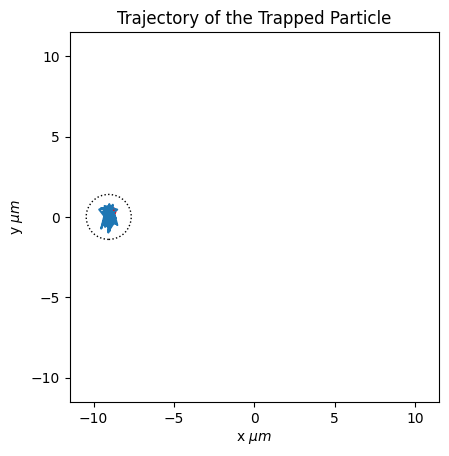

In [8]:
# Filter the whole trajectory df to get the trajectory of the trapped particle (track_particle+1)
trj_track = trj_unwrapped[trj_unwrapped.index.get_level_values(2) == track_particle+1]
x_track = trj_track.x.tolist()
y_track = trj_track.y.tolist()
# Obtaining the time data - frames
fr_track = trj_track.index.get_level_values(1).tolist()

# For circle
fig, ax = plt.subplots(dpi=100)

# Plotting the single trajectory
plt.scatter([x_track[0], x_track[-1]], [y_track[0], y_track[-1]], c='red')
plt.plot(x_track, y_track)
plt.xlabel(r"x $\mu{}m$")
plt.ylabel(r"y $\mu{}m$")
plt.xlim(bounds["x_min"], bounds["x_max"])
plt.ylim(bounds["y_min"], bounds["y_max"])
plt.title("Trajectory of the Trapped Particle")

circle = plt.Circle((x_track[0], y_track[0]), particle_radius, color='black', fill=False, linestyle='dotted')
ax.set_aspect('equal', 'box')
ax.add_patch(circle)

plt.show()

#### Rutine for repetition and storing of the data obtained

We want to keep track of a bunch of samples in which the trap is affected by the enviornment. For this, a rutine should be made in order to store the track particle, and the important parameters of the simulation, so that the tests can be recreated easily, having all the parameters established, and also to see how the different parameters affect the result. For this, the following steps should be made:
 - Create a file in which the information will be stored (dataframe like data, with the different trajectories of the test particle, and then sections of the parameters used).
 - Save in each iteration correctly the simulation. Its important to manage a consistent format and intuitive format for all the trajectories (maybe replicate the one used for all the trajectories of the system).
 - Store the parameters in which the iteration of the simulations where made.

This data can then be used, regardless of the simulation run, it would be a one time compiling (which probably would take a fair amount of time based on the lattice size).

In [9]:
# Running multiple simulations and storing the data in a csv
# Save this first run

# Start a counter for the runs
run_number = 1

# Save the data as dfs, so that the data can be organized better in a csv
data_saving = pd.DataFrame({
    "run_number": [run_number] * len(fr_track),
    "frame": fr_track,
    "x_pos": x_track,
    "y_pos": y_track
})

dir_save = r"./results/"
save_name = "results_1000_trap"
direction = dir_save + save_name + ".csv"

os.makedirs(dir_save, exist_ok=True) # Check that folder exists

data_saving.to_csv(direction, mode='w', index=False, header=True) # Mode write (w), we use Append (a) for the following runs

With the .csv file already generated, then we can use this file to store the following runs, designated by the user.

In [10]:
n_runs = 1000
for i in range(n_runs - 1):
    # i + 2, for going from 1 to the n_runs, and as the first runs was already made
    run_number = i + 2
    sim.seed = np.random.randint(1000000)
    sim.generate_scripts()
    sim.run()
    sim.load()
    trj = sim.lazy_read[::10]
    trj_prime, bounds_df = mgc.load_trj(sim.base_name+".lammpstrj", slice(0,-1,10))
    bounds = bounds_df.loc[0]
    trj_unwrapped = mgc.unwrap_trj(trj.drop(columns=['type']), bounds)
    trj_track = trj_unwrapped[trj_unwrapped.index.get_level_values(2) == track_particle+1]
    x_track = trj_track.x.tolist()
    y_track = trj_track.y.tolist()
    fr_track = trj_track.index.get_level_values(1).tolist()
    
    data_saving = pd.DataFrame({
        "run_number": [run_number] * len(fr_track),
        "frame": fr_track,
        "x_pos": x_track,
        "y_pos": y_track
    })
    
    # Now we use Append Mode, and dont overwrite the headers
    data_saving.to_csv(direction, mode='a', index=False, header=False)

We can finally do a .txt so that the parameters in which the simulation was made can be saved. For this we need to consider the important parameters through the simulation. We could add extra notes, nevertheless, the data should speak for itself. The most important parameters in the simulation are (for the case of our particular escenario, which things we could be changing):
 - num_of_particles
 - tilted_field
 - particle_radius (related with the radius of the trap)
 - stiffness_track
 - track_particle (number in the simulation, can be related with the equilibrium position, which in fact its actually given by time 0*)
 - tot_time

In [11]:
from datetime import datetime

# Add the parameters that want to be saved
params = {
    "number of runs": n_runs,
    "number of particles": num_of_particles,
    "tilted field": tilted_field,
    "particle radius": particle_radius,
    "stiffness of the trap": stiffness_track,
    "track particle id": track_particle,
    "total time per simulation (secs)": tot_time,
    "file generated": direction,
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

dir_txt = dir_save + save_name + "_parameters.txt"

with open(dir_txt, "w") as f:
    for key, value in params.items():
        f.write(f"{key}: {value}\n")